In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/potato_disease",
                                                              shuffle=True,
                                                              image_size = (IMG_SIZE,IMG_SIZE),
                                                              batch_size = 32)

Found 2152 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names

In [ ]:
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

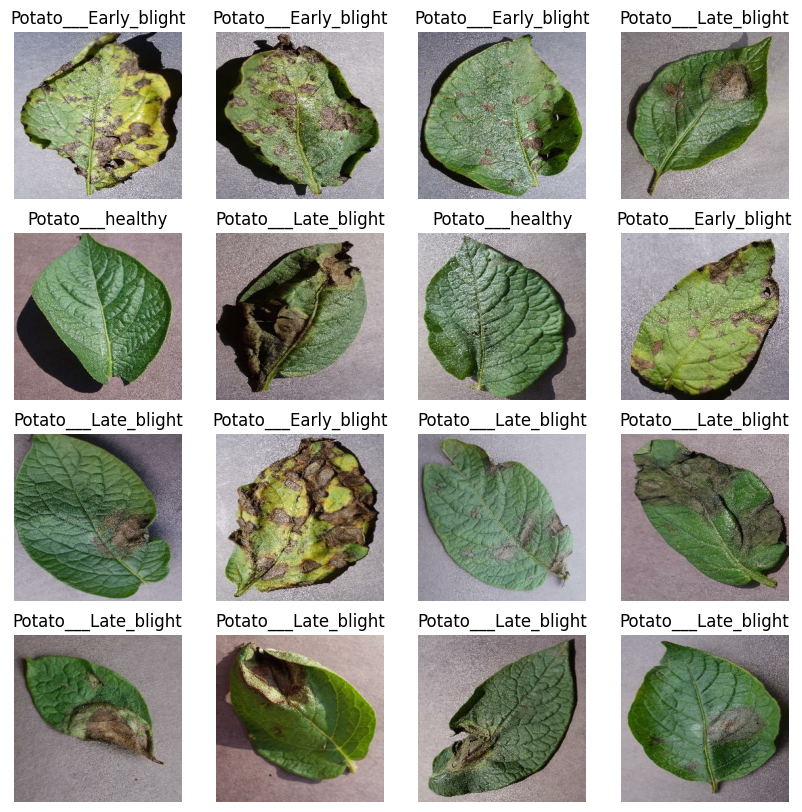

In [ ]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_name[label[i]])
    plt.axis("off")


In [ ]:
def create_data_batch(dataset,test_size = 0.1,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=1000):
  ds_size = len(dataset)
  if shuffle:
    dataset = dataset.shuffle(shuffle_size,seed=12)
  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)

  train_ds = dataset.take(train_size)
  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = create_data_batch(dataset)

In [ ]:
len(train_ds),len(test_ds),len(val_ds)

(54, 8, 6)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Building the Model

  Creating a Layer for Resizing and Normalization
  Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

  You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
rescale_resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### Apply Data Agumentation

In [ ]:
data_agumentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
preprocessing_model = tf.keras.Sequential([
    data_agumentation,
    rescale_resize
])

In [ ]:
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
NUM_OF_CLASS = 3

model = models.Sequential([
    preprocessing_model,
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(NUM_OF_CLASS,activation="softmax")
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [ ]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["acc"])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=val_ds,verbose=1,batch_size=BATCH_SIZE)

Epoch 1/10
54/54 [==============================] - 474s 6s/step - loss: 0.9075 - acc: 0.4832 - val_loss: 0.8971 - val_acc: 0.5260
Epoch 2/10
54/54 [==============================] - 275s 5s/step - loss: 0.6946 - acc: 0.6910 - val_loss: 0.5417 - val_acc: 0.7500
Epoch 3/10
54/54 [==============================] - 278s 5s/step - loss: 0.4442 - acc: 0.8009 - val_loss: 0.6133 - val_acc: 0.6667
Epoch 4/10
54/54 [==============================] - 277s 5s/step - loss: 0.3463 - acc: 0.8600 - val_loss: 0.2616 - val_acc: 0.8854
Epoch 5/10
54/54 [==============================] - 278s 5s/step - loss: 0.2654 - acc: 0.8889 - val_loss: 0.2457 - val_acc: 0.9010
Epoch 6/10
54/54 [==============================] - 276s 5s/step - loss: 0.2544 - acc: 0.9045 - val_loss: 0.1988 - val_acc: 0.9167
Epoch 7/10
54/54 [==============================] - 276s 5s/step - loss: 0.2192 - acc: 0.9138 - val_loss: 0.2083 - val_acc: 0.9115
Epoch 8/10
54/54 [==============================] - 276s 5s/step - loss: 0.1993 - a

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 11s 1s/step - loss: 0.1254 - acc: 0.9492


In [ ]:
scores

[0.12543700635433197, 0.94921875]

#### Plotting the Loss And Accuracy Score

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
len(history.history["loss"])

10

In [ ]:
acc = history.history["acc"]
loss = history.history['loss']
val_acc = history.history["val_acc"]
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

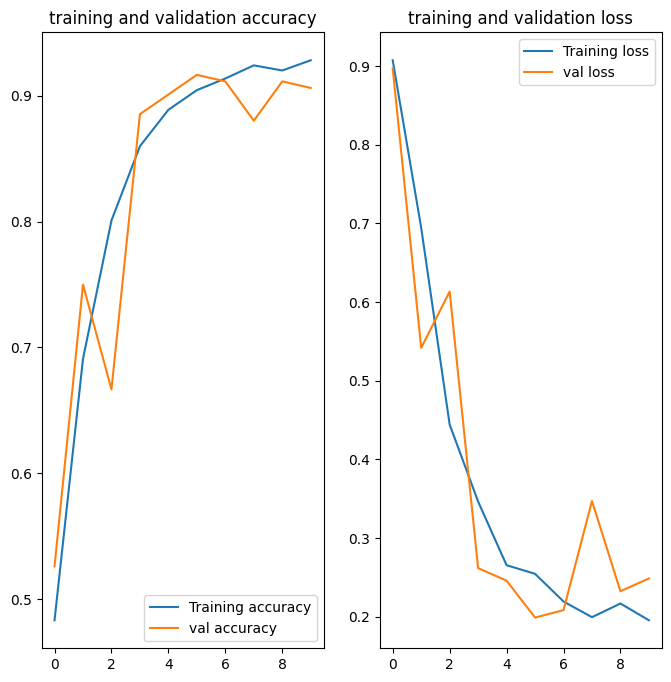

In [ ]:
# Accuracy for training and val
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training accuracy")
plt.plot(range(EPOCHS),val_acc,label="val accuracy")
plt.legend()
plt.title("training and validation accuracy")

# loss for val and training
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="val loss")
plt.legend()
plt.title("training and validation loss")

#### Run Prediction on Simple Image

actual image
1/1 [==============================] - 2s 2s/step
predicted label:Potato___healthy


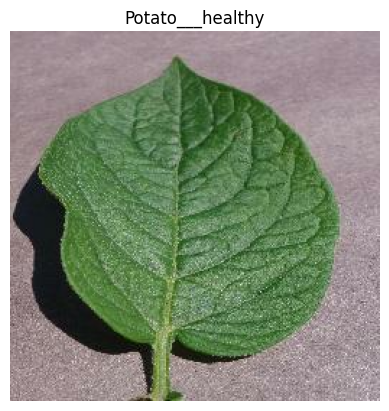

In [ ]:
import numpy as np

for image_batch,label_batch in test_ds.take(1):
  print("actual image")
  predicted = model.predict(image_batch)
  print(f"predicted label:{class_name[np.argmax(predicted[0])]}")
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_name[label_batch[0]])
  plt.axis('off')

#### Write a Function For Inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os

In [ ]:
save_path = "/content/drive/My Drive/my_model/modelv1.h5"

# Ensure that the directory exists, create it if it doesn't
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model as an .h5 file directly to the specified path
model.save(save_path)